In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
import sklearn

출처: https://musicinformationretrieval.com/

# Zero-crossing rate

In [3]:
x, sr = librosa.load('../audio/simple_loop.wav')
ipd.Audio(x, rate=sr)

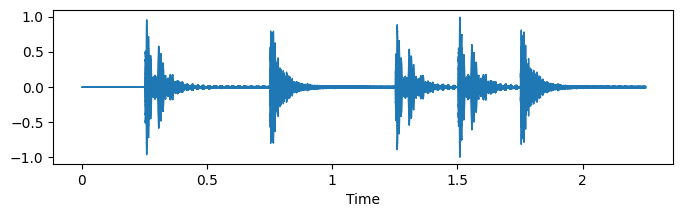

In [4]:
plt.figure(figsize=(8,2))
librosa.display.waveshow(x, sr=sr)
plt.show()

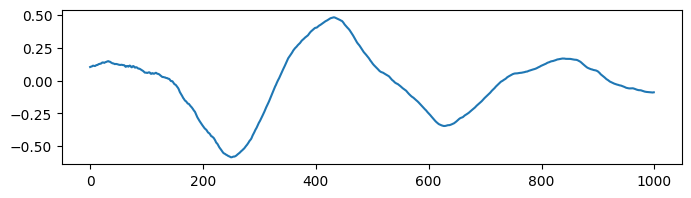

In [5]:
# zoom in
n0 = 6500; n1 = 7500
plt.figure(figsize=(8, 2))
plt.plot(x[n0:n1])

In [6]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

5


In [7]:
zcrs = librosa.feature.zero_crossing_rate(x)
print(zcrs.shape)

(1, 97)


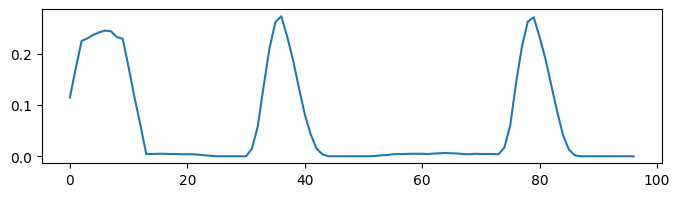

In [8]:
plt.figure(figsize=(8,2))
plt.plot(zcrs[0])

처음 부분의 높은 zero-crossing rate은 무음의 0 사이 작은 진동 때문이다. 

(-0.0001, 0.0001)

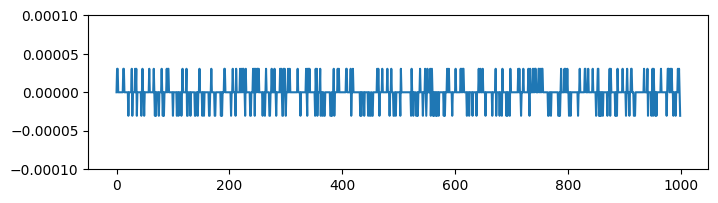

In [9]:
plt.figure(figsize=(8,2))
plt.plot(x[:1000])
plt.ylim(-0.0001, 0.0001)

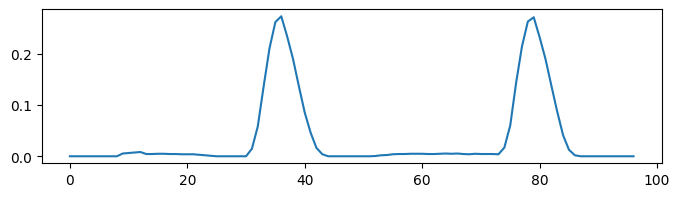

In [10]:
# 작은 수를 더해 이를 방지
zcrs = librosa.feature.zero_crossing_rate(x + 0.0001)
plt.figure(figsize=(8, 2))
plt.plot(zcrs[0])

# Energy and RMSE
- librosa 사용

In [11]:
librosa.get_duration(y=x, sr=sr)

2.2500226757369615

In [12]:
hop_length = 256
frame_length = 512
energy = np.array([
    sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)])
energy.shape

(194,)

In [13]:
rmse = librosa.feature.rms(y=x, frame_length=frame_length, hop_length=hop_length, center=True)
rmse = rmse[0]
rmse.shape

(194,)

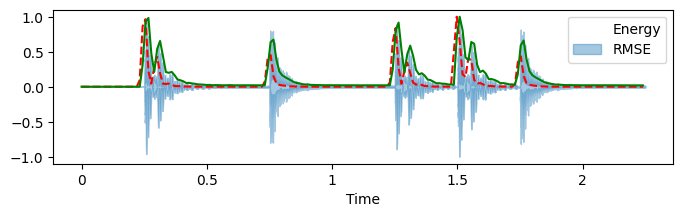

In [14]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

plt.figure(figsize=(8,2))
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))

In [15]:
# remove leading silence from a signal.

def strip(x, frame_length, hop_length):

    # Compute RMSE.
    rmse = librosa.feature.rms(y=x, frame_length=frame_length, hop_length=hop_length, center=True)
    
    # Identify the first frame index where RMSE exceeds a threshold.
    thresh = 0.01
    frame_index = 0
    while rmse[0][frame_index] < thresh:
        frame_index += 1
        
    # Convert units of frames to samples.
    start_sample_index = librosa.frames_to_samples(frame_index, hop_length=hop_length)
    
    # Return the trimmed signal.
    return x[start_sample_index:]

In [16]:
y = strip(x, frame_length, hop_length)
ipd.Audio(y, rate=sr)

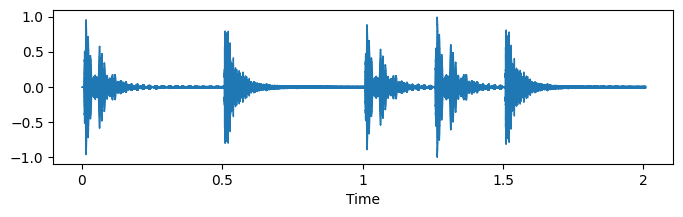

In [17]:
plt.figure(figsize=(8,2))
librosa.display.waveshow(y, sr=sr)

# Constant-Q Transform & Chromagram

## Constant-Q
- 푸리에 변환과 달리 멜 스케일과 유사한 **Constant-Q 변환**은 로그 간격의 주파수 축을 사용한다.
- 수학 및 신호 처리에서 CQT 및 VQT로 알려진 Constant-Q 변환 및 variable-Q 변환은 데이터 시리즈를 주파수 도메인으로 변환한다. 푸리에 변환과 관련이 있으며 복잡한 Morlet 웨이블릿 변환과 매우 밀접하게 관련되어 있다. 이 디자인은 음악적 표현에 적합하다. (wiki)
- https://en.wikipedia.org/wiki/Constant-Q_transform

In [18]:
# example
x, sr = librosa.load('../audio/simple_piano.wav')
ipd.Audio(x, rate=sr)

In [19]:
fmin = librosa.midi_to_hz(36)
hop_length = 512
C = librosa.cqt(x, sr=sr, fmin=fmin, n_bins=72, hop_length=hop_length)

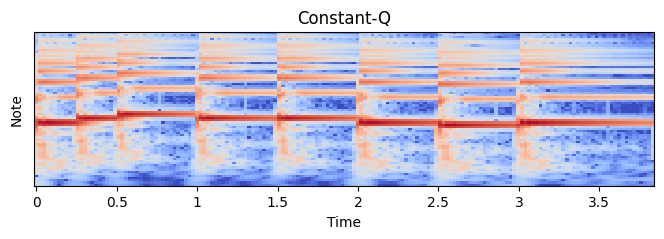

In [20]:
logC = librosa.amplitude_to_db(np.abs(C))
plt.figure(figsize=(8, 2))
plt.title("Constant-Q")
librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')

## 크로마그램(Chromagram)

- 크로마 벡터는 12개 원소의 피쳐 벡터이며 각 피치 클래스의 에너지가 신호에 얼마나 있는지를 보인다. {C, C#, D, D#, E, ..., B}

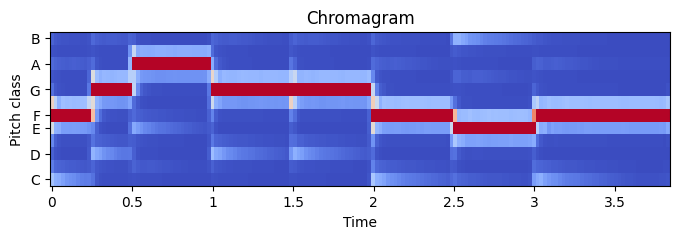

In [21]:
chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(8, 2))
plt.title("Chromagram")
librosa.display.specshow(data=chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

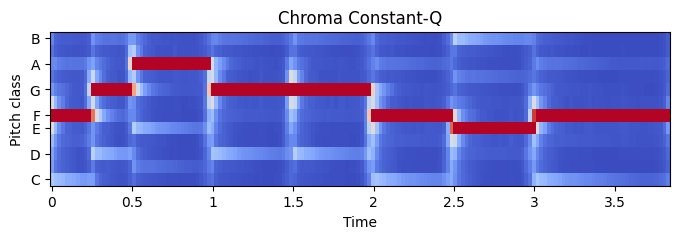

In [22]:
# chroma cqt
chromagram = librosa.feature.chroma_cqt(y=x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(8, 2))
plt.title("Chroma Constant-Q")
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

## Chroma energy normalized statistics (CENS) 

- CENS feature는 큰 윈도우에 대한 통계를 통해 템포, 아티큘레이션, 트릴(trill) 및 아르페지오 화음과 같은 음악 ornament의 local 편차를 완화한다. CENS는 오디오 매칭 및 유사성과 같은 작업에 가장 적합하다.

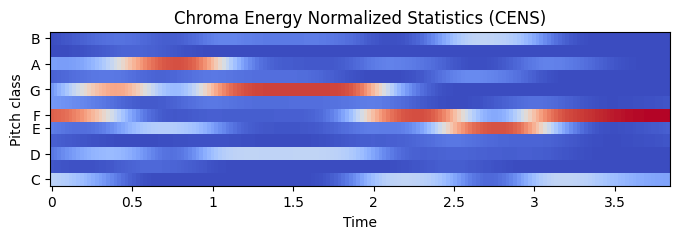

In [23]:
chromagram = librosa.feature.chroma_cens(y=x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(8,2))
plt.title("Chroma Energy Normalized Statistics (CENS)")
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

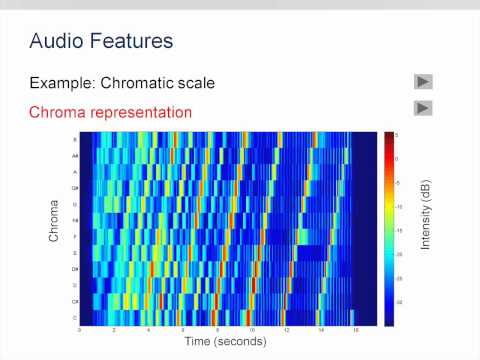

In [24]:
# 참고 비디오
ipd.display(ipd.YouTubeVideo("PF05xP1NqUM", width=16*30, height=9*30) )

# 스펙트럼 피쳐 (Spectral Features)

In [25]:
x, sr = librosa.load('../audio/simple_loop.wav')
ipd.Audio(x, rate=sr)

## 스펙트럼 중심 (Spectral centroid)

- **spectral centroid**은 스펙트럼의 에너지가 중심이 되는 주파수를 나타낸다. 다음의 가중 평균과 같다:
    - $ f_c = \frac{\sum_k S(k) f(k)}{\sum_k S(k)} $
    - 여기서 $S(k)$는 주파수 빈(bin) $k$에서의 스펙트럼 크기이고, $f(k)$는 빈 $k$에서의 주파수이다.

In [26]:
spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
spectral_centroids.shape

(97,)

In [27]:
#x축
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

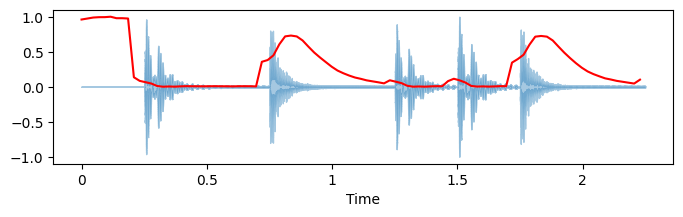

In [28]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

plt.figure(figsize=(8,2))
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes

- zero crossing rate과 유사하게 신호 시작 부분에서 스펙트럼 중심에 가짜 상승이 있다. 그것은 시작 부분의 무음이 고주파 성분이 우세할 기회를 가질 정도로 작은 진폭을 가지고 있기 때문이다. 이에 대한 한 가지 해킹은 스펙트럼 중심을 계산하기 전에 작은 상수를 추가하여 조용한 부분에서 중심을 0으로 이동시키는 것이다.

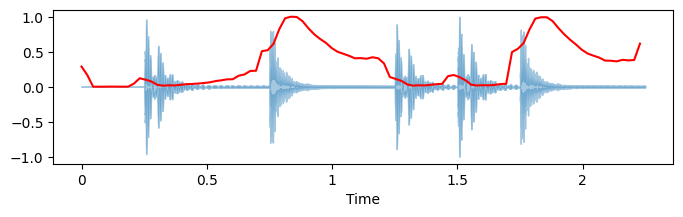

In [29]:
spectral_centroids = librosa.feature.spectral_centroid(y=x+0.01, sr=sr)[0]

plt.figure(figsize=(8,2))
librosa.display.waveshow(y=x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes

## 스펙트럼 대역폭(Spectral bandwidth)

- `librosa.feature.spectral_bandwidth`는 order-$p$ 스펙트럼 대역폭을 계산한다:
    - $ \left( \sum_k S(k) \left(f(k) - f_c \right)^p \right)^{\frac{1}{p}} $
    - 여기서 $S(k)$는 주파수 bin $k$에서의 스펙트럼 크기, $f(k)$는 bin $k$에서의 주파수, $f_c$는 스펙트럼 중심이다. 
    - $p = 2$이면 가중 표준편차와 같다.

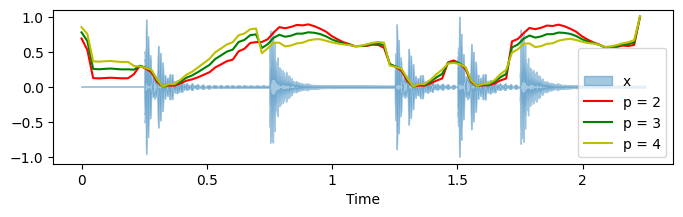

In [30]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y=x+0.01, sr=sr, p=4)[0]

plt.figure(figsize=(8,2))
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(['','x','p = 2', 'p = 3', 'p = 4'])

## 스펙트럼 대비 (Spectral contrast)

- 스펙트럼 대비는 스펙트럼 피크(peak), 스펙트럼 밸리(valley) 및 각 주파수 하위밴드(subband)의 차이를 고려한다.

- `librosa.feature.spectral_contrast`는 각 시간 프레임에 대해 6개의 하위밴드에 대한 스펙트럼 대비를 계산한다.

In [31]:
spectral_contrast = librosa.feature.spectral_contrast(y=x, sr=sr)
spectral_contrast.shape

(7, 97)

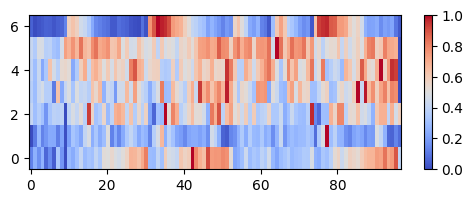

In [32]:
plt.figure(figsize=(6,2))
plt.imshow(normalize(spectral_contrast, axis=1), aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar()

## 스펙트럼 롤오프 (Spectral rolloff)

- Spectral rolloff는 총 스펙트럼 에너지의 특정 퍼센티지보다 밑에 있는 주파수를 말한다.

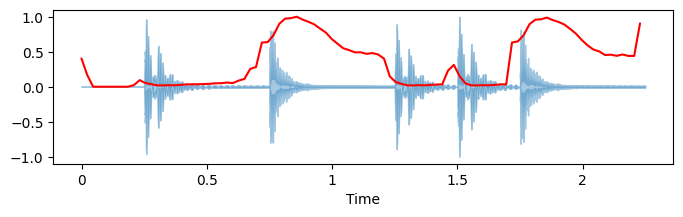

In [33]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=x+0.01, sr=sr, roll_percent=0.85)[0]

plt.figure(figsize=(8,2))
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

- 위 내용들은 앞으로 중간중간 등장할 예정이다.